In [41]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from time import time
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [68]:
from sklearn.preprocessing import StandardScaler
import statistics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten

from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import roc_auc_score , accuracy_score , precision_score, recall_score ,confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns

In [42]:
def power_spectral(fmin, fmax, n_fft, raw, info):
    #raw = mne.io.RawArray(updatedvalues, info)
    
    raw.plot_psd(fmin = fmin, fmax = fmax, n_fft=n_fft) 
    plt.show()

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/seina-scalp-epilepsy-dataset/PN00-1.edf
/kaggle/input/seina-scalp-epilepsy-dataset/PN00-4.edf
/kaggle/input/seina-scalp-epilepsy-dataset/PN00-5.edf
/kaggle/input/seina-scalp-epilepsy-dataset/PN00-2.edf
/kaggle/input/seina-scalp-epilepsy-dataset/PN00-3.edf


In [43]:
raw = mne.io.read_raw_edf('/kaggle/input/seina-scalp-epilepsy-dataset/PN00-1.edf')
raw.load_data()
info = raw.info

print(info['sfreq'], 'Hz')
print(info['chs'][0])

Extracting EDF parameters from /kaggle/input/seina-scalp-epilepsy-dataset/PN00-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1343999  =      0.000 ...  2624.998 secs...
512.0 Hz
{'cal': 1.0, 'logno': 1, 'scanno': 1, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'EEG Fp1', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.9s finished


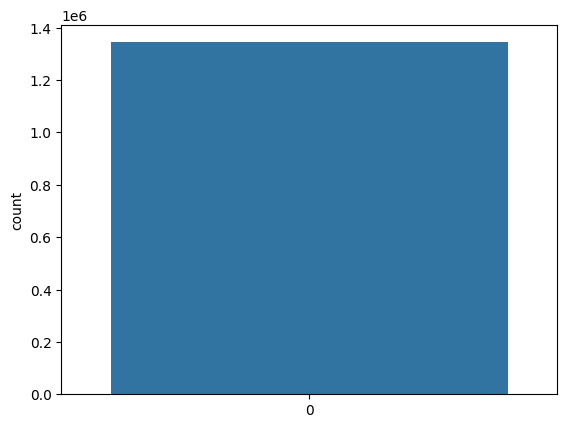

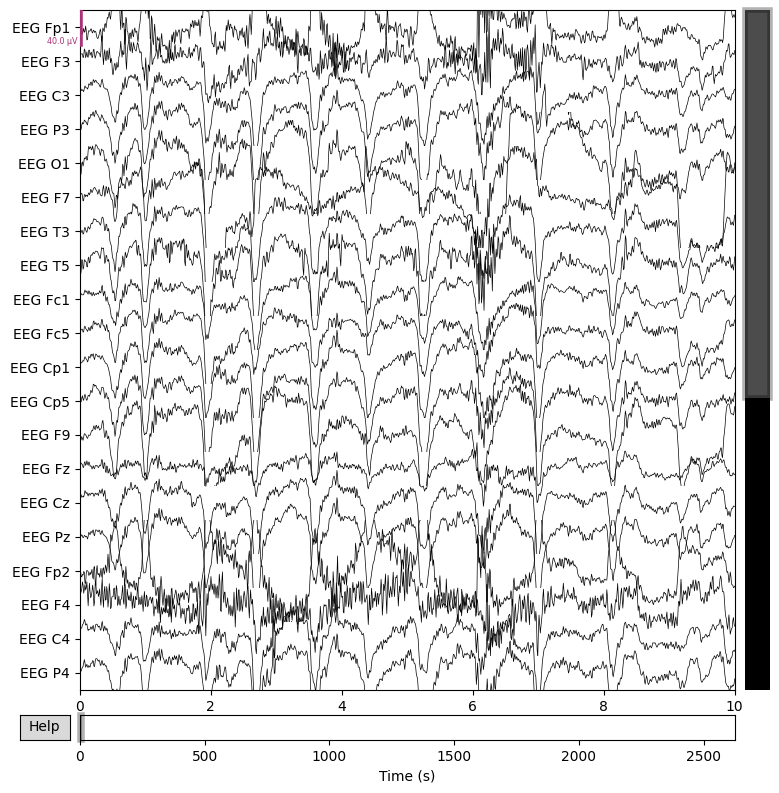

In [44]:
raw.filter(0.5,30)
raw.plot()
plt.show()

In [45]:
def run_ica(method, fit_params=None):
    ica = ICA(n_components=20, method=method, fit_params=fit_params,
              max_iter='auto', random_state=0)
    t0 = time()
    ica.fit(raw)
    fit_time = time() - t0
    title = ('ICA decomposition using %s (took %.1fs)' % (method, fit_time))
    ica.plot_components(title=title)

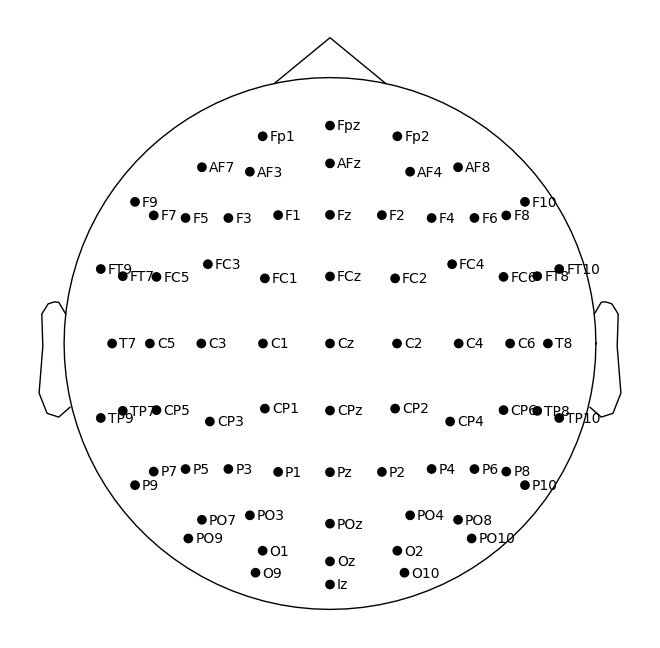

In [46]:
raw.set_channel_types({'2':'ecg','1': 'ecg' })


standard_1020_montage = mne.channels.make_standard_montage('easycap-M1')
standard_1020_montage.plot()
plt.show()

In [47]:
raw.rename_channels({'EEG Fp1':'Fp1', 'EEG F3':'F3', 'EEG C3':'C3', 'EEG P3':'P3', 'EEG O1':'O1', 
'EEG F7':'F7', 'EEG T3':'C1', 'EEG T5':'T7', 'EEG Fc1':'FC1', 'EEG Fc5':'FC5', 'EEG Cp1':'CP1', 
'EEG Cp5':'CP5', 'EEG F9':'F9', 'EEG Fz':'Fz', 'EEG Cz':'Cz', 'EEG Pz':'Pz', 'EEG Fp2':'Fp2', 
'EEG F4':'F4', 'EEG C4':'C4', 'EEG P4':'P4', 'EEG O2':'O2', 'EEG F8':'F8', 'EEG T4':'C2', 
'EEG T6':'T8', 'EEG Fc2':'FC2', 'EEG Fc6':'FC6', 'EEG Cp2':'CP2', 'EEG Cp6':'CP6', 
'EEG F10':'F10', 'EKG EKG':'AF7', 'SPO2':'Iz', 'HR':'AF8', 'MK':'Fpz'})

<RawEDF | PN00-1.edf, 35 x 1344000 (2625.0 s), ~358.9 MB, data loaded>

In [48]:
raw.set_montage(standard_1020_montage)

<RawEDF | PN00-1.edf, 35 x 1344000 (2625.0 s), ~358.9 MB, data loaded>

In [49]:
events = mne.find_events(raw, stim_channel = '2')
print (events)

[]


Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [ 0 16]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 112 significant peaks
Number of EOG events detected: 112
Not setting metadata
112 matching events found
No baseline correction applied
Using data from preloaded Raw for 112 events and 513 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
No projector speci

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


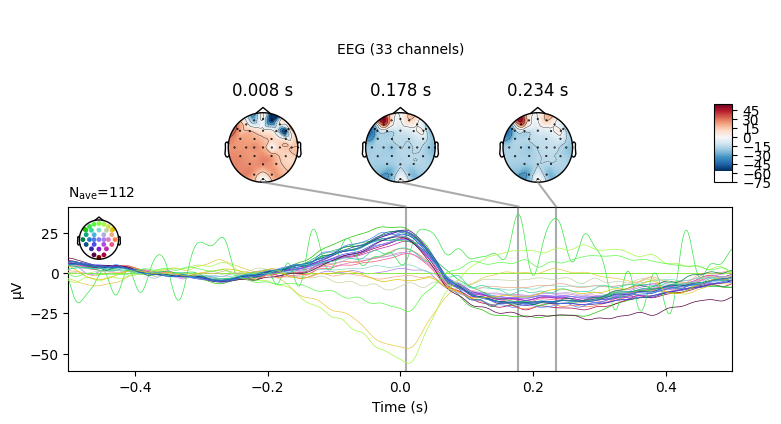

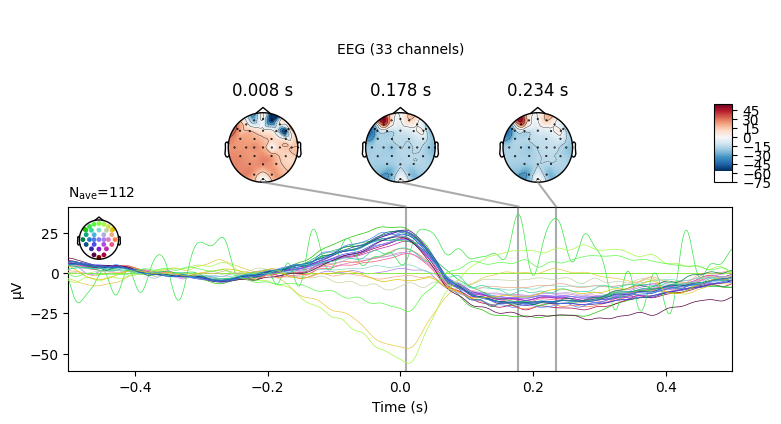

In [50]:
eog_evoked = create_eog_epochs(raw, ch_name=['Fp1','Fp2']).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Using channel 1 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 5120 samples (10.000 sec)

Number of ECG events detected : 2710 (average pulse 61 / min.)
Not setting metadata
2710 matching events found
No baseline correction applied
Using data from preloaded Raw for 2710 events and 513 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


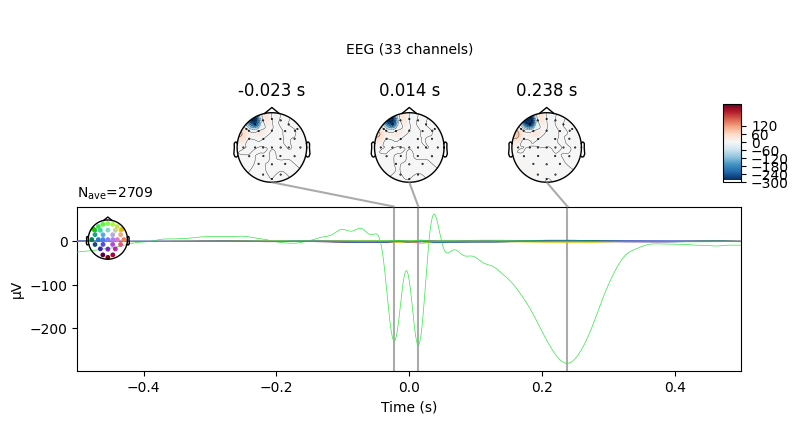

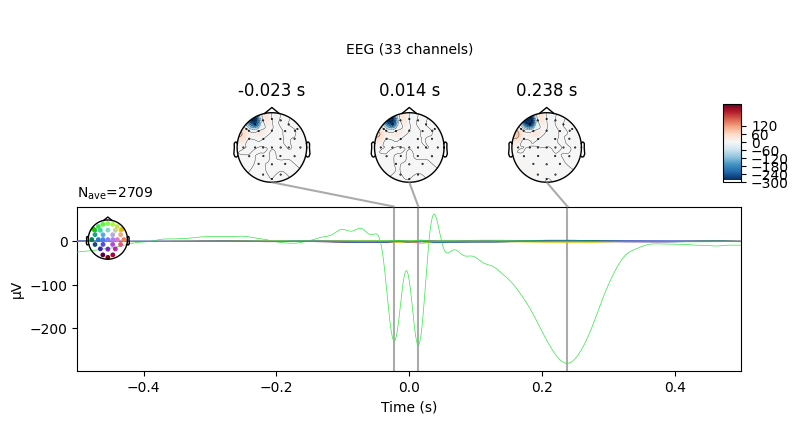

In [51]:
# ECH Ephochs

ecg_evoked = create_ecg_epochs(raw).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

In [52]:
filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
# filt_raw = raw.copy()

ica = ICA(n_components=25, max_iter='auto',method = 'fastica', random_state=97)
print ("ICA function")
ica.fit(filt_raw)
ica
print ("ICA Done")

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


ICA function
Fitting ICA to data using 33 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    1.8s finished


Selecting by number: 25 components
Fitting ICA took 156.3s.
ICA Done


Creating RawArray with float64 data, n_channels=27, n_times=1344000
    Range : 0 ... 1343999 =      0.000 ...  2624.998 secs
Ready.


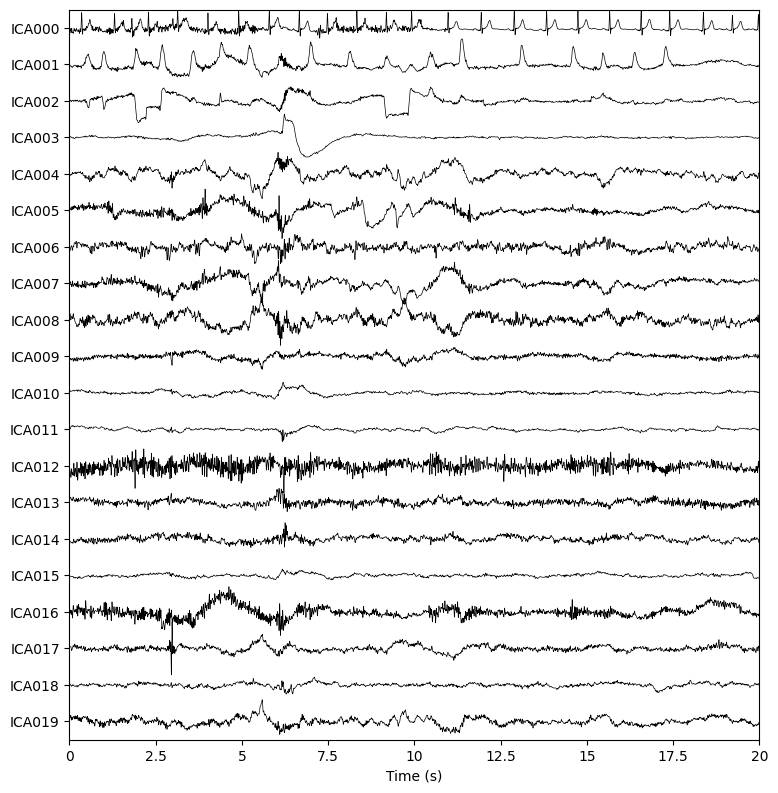

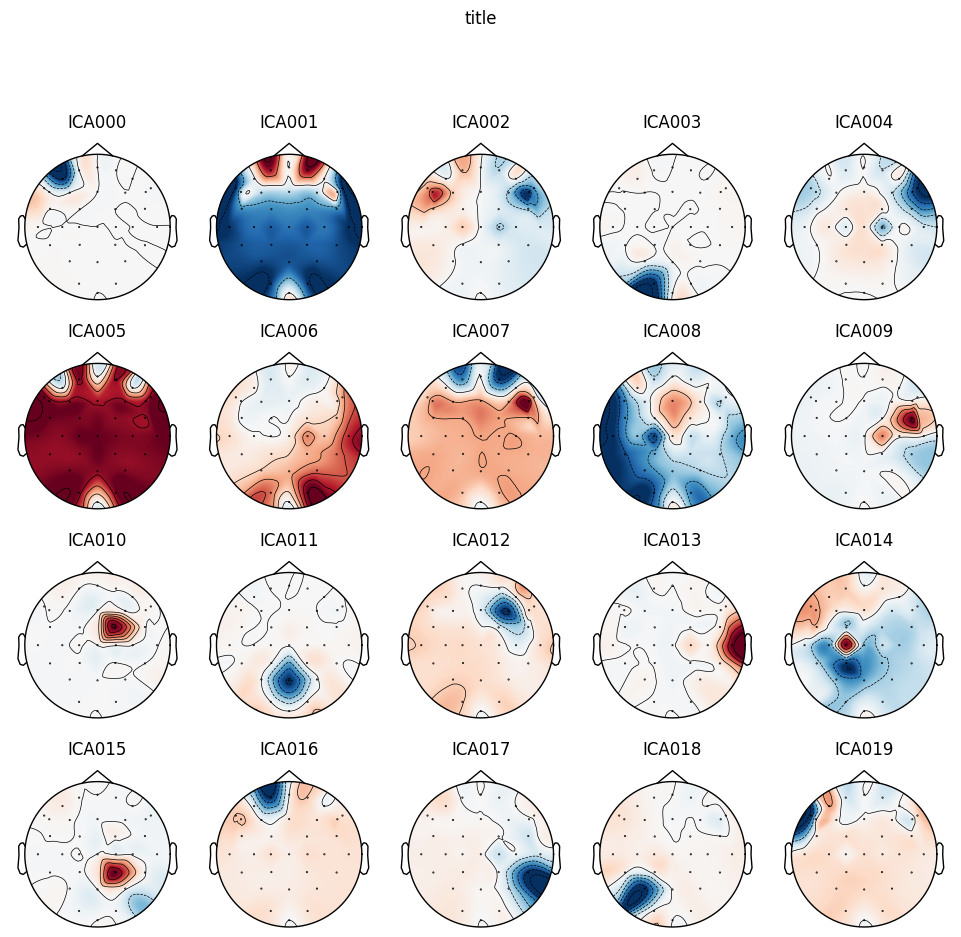

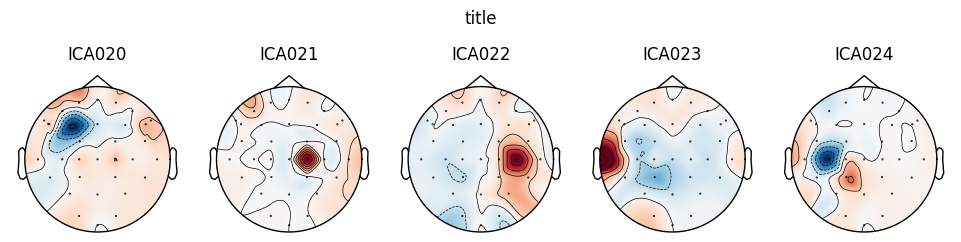

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 33 PCA components


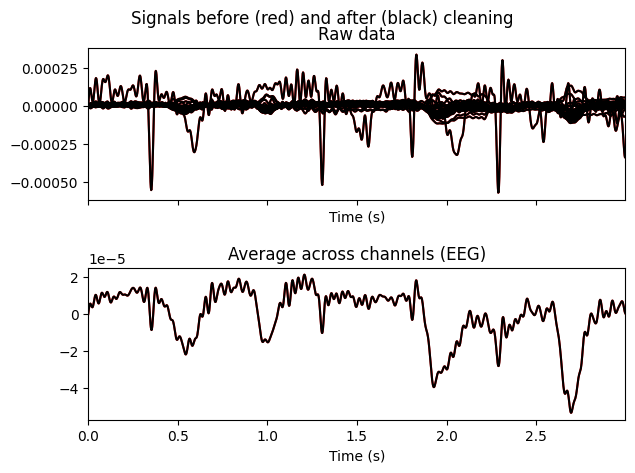

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1312 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1312 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1312 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1312 matching events found
No baseline correction applied
0 projection items activated


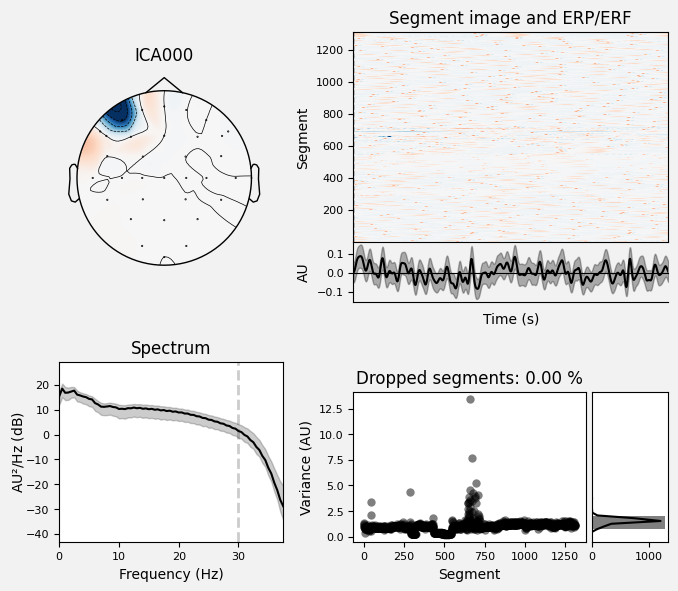

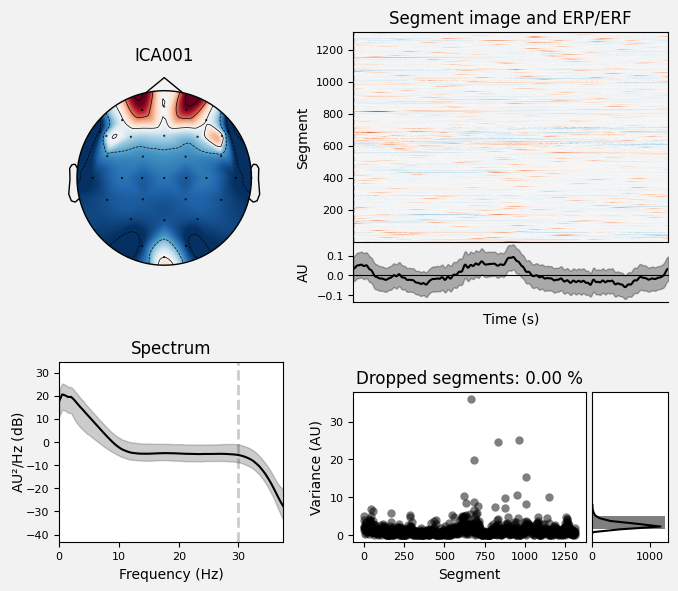

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [53]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)
ica.plot_components(title="title")

# blinks
ica.plot_overlay(raw, picks='eeg')

ica.plot_properties(raw, picks=[0, 1])

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 25 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 0 ICA components
    Projecting back using 33 PCA components


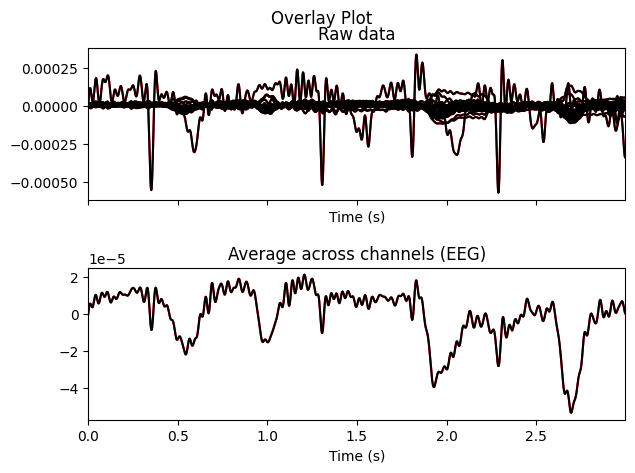

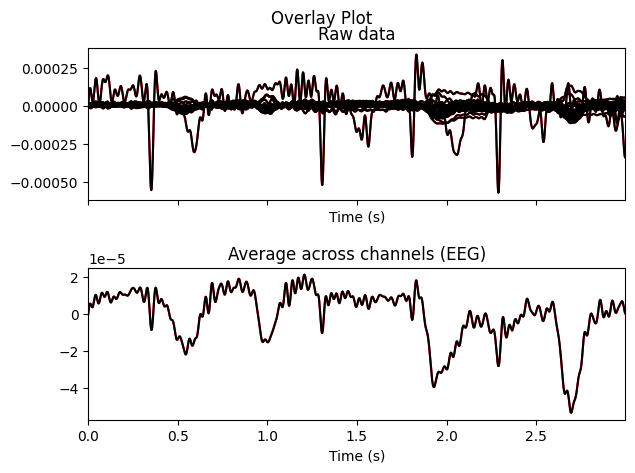

In [54]:
reconst_raw = raw.copy()
raw.load_data()
ica.apply(reconst_raw, n_pca_components =15, )
ica.plot_overlay(reconst_raw,title = "Overlay Plot")

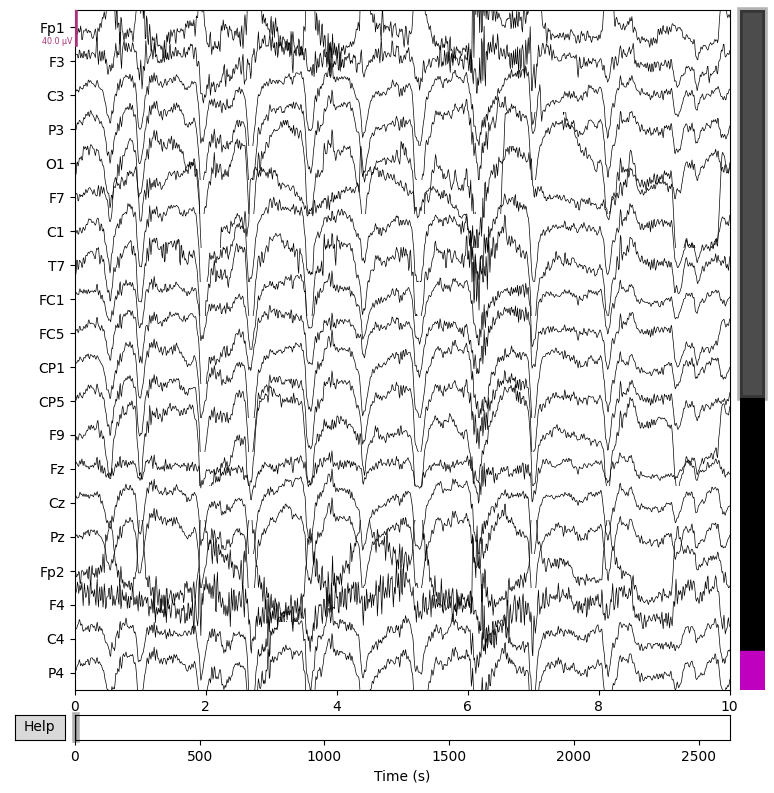

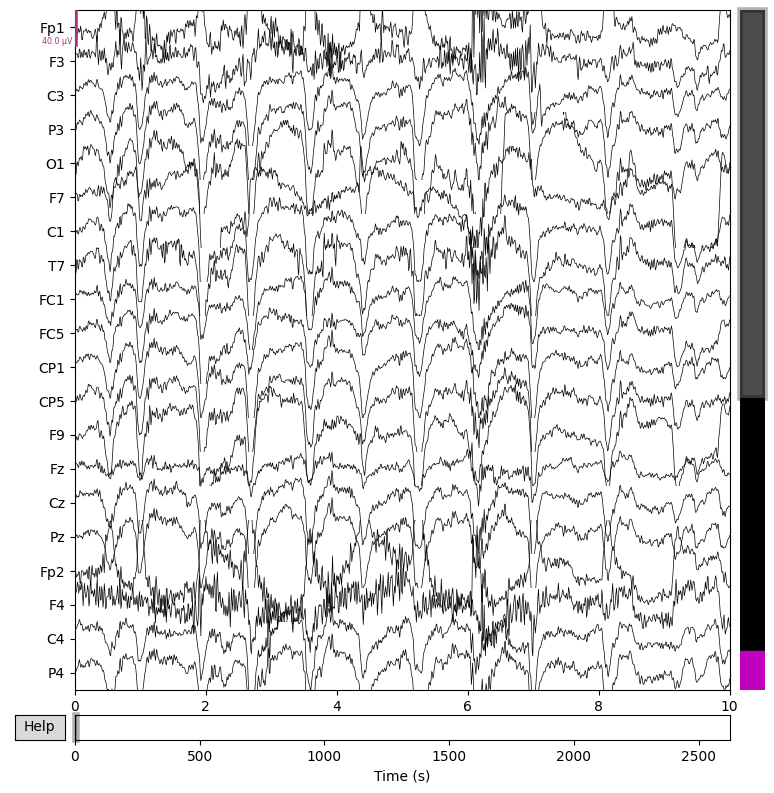

In [55]:
reconst_raw.plot(title = "Filtered plot")
raw.plot(title = "Original plot")
plt.show()

In [56]:
df = reconst_raw.to_data_frame()
print(df.head())
print(df.describe())

       time       Fp1        F3        C3        P3         O1        F7  \
0  0.000000 -0.000008  0.000052  0.000084  0.000021  -0.000003 -0.000039   
1  0.001953 -1.684509  1.949637  1.708186 -0.463298  -3.735232  0.328152   
2  0.003906 -3.217647  3.760677  3.307700 -0.908889  -7.270108  0.625947   
3  0.005859 -4.467752  5.310955  4.700745 -1.317079 -10.414713  0.869064   
4  0.007812 -5.342111  6.513535  5.810356 -1.663547 -13.002604  1.044042   

         C1         T7       FC1  ...       FC6       CP2       CP6       F10  \
0 -0.000020   0.000062 -0.000343  ...  0.000014  0.000019  0.000091 -0.000020   
1 -0.595845  -3.433199  1.820481  ...  0.158663  0.578708  1.004108  1.430733   
2 -1.184213  -6.661028  3.541707  ...  0.295436  1.136047  1.939114  2.785758   
3 -1.752658  -9.486288  5.071785  ...  0.394506  1.652139  2.744144  3.998972   
4 -2.284003 -11.734060  6.337529  ...  0.450520  2.111690  3.376494  5.024224   

            AF7   Iz  AF8             1             2   

In [57]:
sampling_rate = 512

normal_eeg_first = df.loc[0:604160]
abnormal_eeg = df.loc[604160:625664]
normal_eeg_last = df.loc[625664:]

normal_eeg = pd.concat([normal_eeg_first,normal_eeg_last], axis=0)

In [58]:
normal_eeg.describe()

time           Fp1            F3            C3            P3  \
count  1.322497e+06  1.322497e+06  1.322497e+06  1.322497e+06  1.322497e+06   
mean   1.314312e+03 -9.753099e-03  4.174431e-03  4.591470e-03  5.154880e-03   
std    7.637721e+02  2.177752e+01  1.346538e+01  1.695956e+01  2.200207e+01   
min    0.000000e+00 -3.456296e+02 -2.766073e+02 -2.643040e+02 -2.768288e+02   
25%    6.457500e+02 -8.344368e+00 -4.365447e+00 -3.950800e+00 -5.118586e+00   
50%    1.333498e+03 -2.425442e+00  3.924698e-01  2.167548e+00  2.476068e+00   
75%    1.979248e+03  4.550122e+00  4.858857e+00  7.234345e+00  8.833498e+00   
max    2.624998e+03  5.794606e+02  2.723322e+02  1.664241e+02  7.341254e+02   

                 O1            F7            C1            T7           FC1  \
count  1.322497e+06  1.322497e+06  1.322497e+06  1.322497e+06  1.322497e+06   
mean   9.135393e-04 -1.263180e-02 -6.004251e-03  7.255875e-04  3.926952e-03   
std    4.853776e+01  2.328480e+01  2.052663e+01  2.053033e+01  1.501407e+01   
min   -8.657167e+02 -2.805111e+02 -2.701455e+02 -2.447898e+02 -2.811166e+02   
25%   -6.863594e+00 -7.225191e+00 -5.311548e+00 -5.557936e+00 -2.822478e+00   
50%    2.313569e+00  2.466865e-01  2.262068e+00  2.525409e+00  1.909020e+00   
75%    1.037718e+01  7.701467e+00  8.589374e+00  9.621416e+00  5.861905e+00   
max    2.034909e+03  2.719590e+02  1.844434e+02  2.154011e+02  1.785968e+02   

       ...           FC6           CP2           CP6           F10  \
count  ...  1.322497e+06  1.322497e+06  1.322497e+06  1.322497e+06   
mean   ...  3.703465e-03  4.657884e-03  8.196651e-03  5.619069e-03   
std    ...  2.127450e+01  2.128103e+01  2.200236e+01  2.953409e+01   
min    ... -2.751559e+02 -2.726141e+02 -4.912194e+02 -2.975941e+02   
25%    ... -6.039023e+00 -4.111258e+00 -5.419455e+00 -1.037999e+01   
50%    ...  1.508403e+00  2.411568e+00  2.464393e+00  2.309211e+00   
75%    ...  7.865801e+00  7.769531e+00  8.948147e+00  1.250200e+01   
max    ...  9.851715e+02  7.722670e+02  3.602225e+02  3.607190e+02   

                AF7         Iz        AF8             1             2  \
count  1.322497e+06  1322497.0  1322497.0  1.322497e+06  1.322497e+06   
mean   1.818748e-02        0.0        0.0  9.936873e-03  5.727318e-02   
std    1.370736e+02        0.0        0.0  1.481721e+02  3.863198e+02   
min   -1.487050e+03        0.0        0.0 -3.828212e+03 -2.966053e+03   
25%   -9.529448e+00        0.0        0.0 -1.360458e+01 -1.708765e+02   
50%    4.216179e+01        0.0        0.0  2.236030e+00 -1.257129e+02   
75%    6.762095e+01        0.0        0.0  1.505821e+01 -1.783740e+01   
max    2.030542e+03        0.0        0.0  3.699311e+03  3.251791e+03   

                Fpz  
count  1.322497e+06  
mean   7.277388e-18  
std    9.274683e-15  
min   -2.888134e-13  
25%   -2.671094e-15  
50%   -4.794085e-17  
75%    2.541648e-15  
max    1.738387e-13  

[8 rows x 36 columns]

In [59]:
abnormal_eeg.describe()

time           Fp1            F3            C3            P3  \
count  21505.000000  21505.000000  21505.000000  21505.000000  21505.000000   
mean    1201.000000      0.627535     -0.109356     -0.263294     -0.237157   
std       12.125201     24.121122     20.200241     33.339895     37.133826   
min     1180.000000    -89.372944    -73.220093   -175.520641   -167.782979   
25%     1190.500000    -14.853415    -13.051329    -18.901409    -21.877280   
50%     1201.000000     -1.501590      1.205953      3.234919      2.998092   
75%     1211.500000     14.831671     13.722999     21.470155     26.162402   
max     1222.000000     95.255544     62.593044    139.711369    114.473886   

                 O1            F7            C1            T7           FC1  \
count  21505.000000  21505.000000  21505.000000  21505.000000  21505.000000   
mean      -0.218258      0.910817      0.318331     -0.173721     -0.232090   
std       41.445388     35.595278     33.402525     37.396394     24.686815   
min     -187.052833   -134.017618   -146.041034   -165.388607    -98.191542   
25%      -25.395598    -19.968633    -20.693922    -22.610758    -15.158065   
50%        3.837141      2.321757      4.095887      2.947435      2.342777   
75%       29.458381     24.454153     23.728390     24.983160     17.233468   
max      131.465130    105.460204    110.034754    109.335794     66.323086   

       ...           FC6           CP2           CP6           F10  \
count  ...  21505.000000  21505.000000  21505.000000  21505.000000   
mean   ...     -0.367113     -0.367771     -0.478468     -0.533796   
std    ...     36.476312     32.925801     40.240921     65.894791   
min    ...   -156.663469   -132.365673   -146.415096   -254.738966   
25%    ...    -22.117695    -19.638098    -24.065269    -39.720611   
50%    ...      1.309768      2.588074      3.420595      7.704088   
75%    ...     23.137946     22.525164     26.348407     42.672305   
max    ...    129.889802    111.680520    139.644273    200.797747   

                AF7       Iz      AF8             1             2  \
count  21505.000000  21505.0  21505.0  21505.000000  21505.000000   
mean      -1.093824      0.0      0.0     -0.884272     -1.020725   
std      132.499558      0.0      0.0     52.008518    415.229481   
min     -656.325596      0.0      0.0   -158.635690   -896.366303   
25%      -24.388889      0.0      0.0    -33.686141   -203.918089   
50%       33.379926      0.0      0.0      2.246660   -119.508665   
75%       64.991423      0.0      0.0     35.127588     32.770674   
max      400.450765      0.0      0.0    199.661199   2294.901958   

                Fpz  
count  2.150500e+04  
mean  -3.331704e-16  
std    9.153303e-15  
min   -3.774557e-14  
25%   -6.405476e-15  
50%   -3.294238e-16  
75%    5.579274e-15  
max    3.988007e-14  

[8 rows x 36 columns]

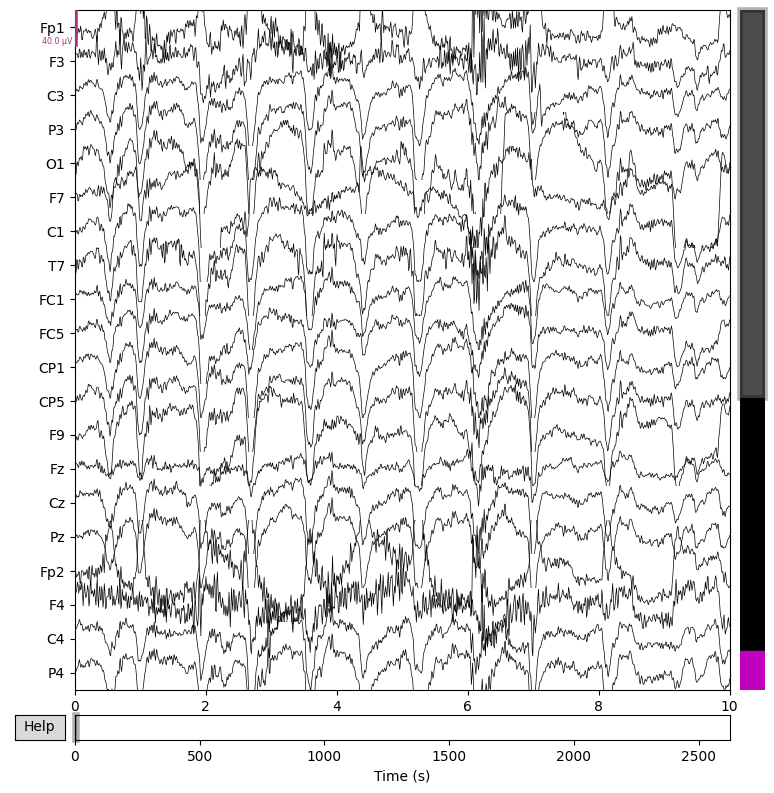

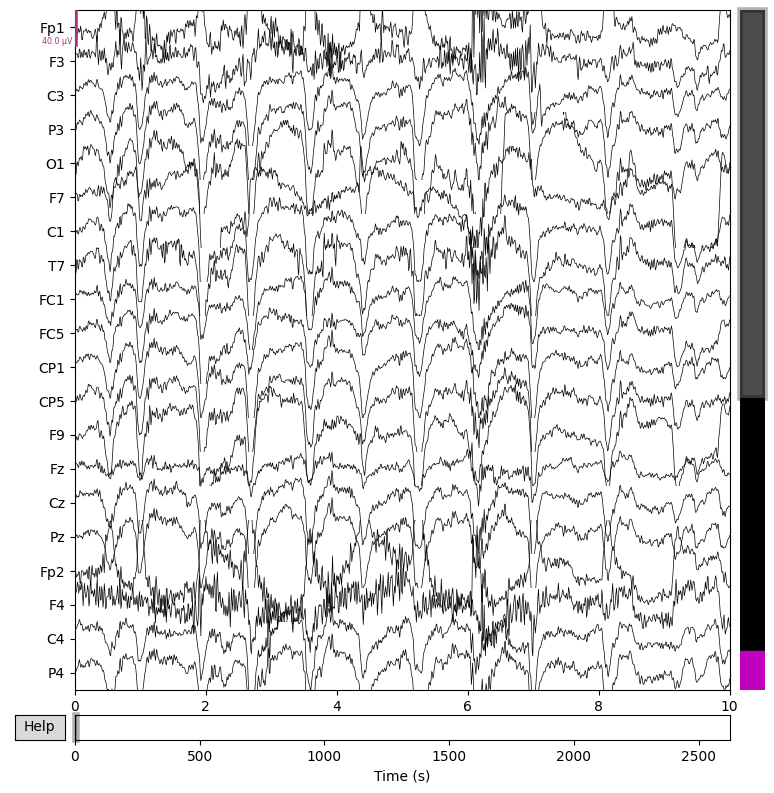

In [60]:
raw.plot(title = "Normal EEG plot", start=0, duration = 10)

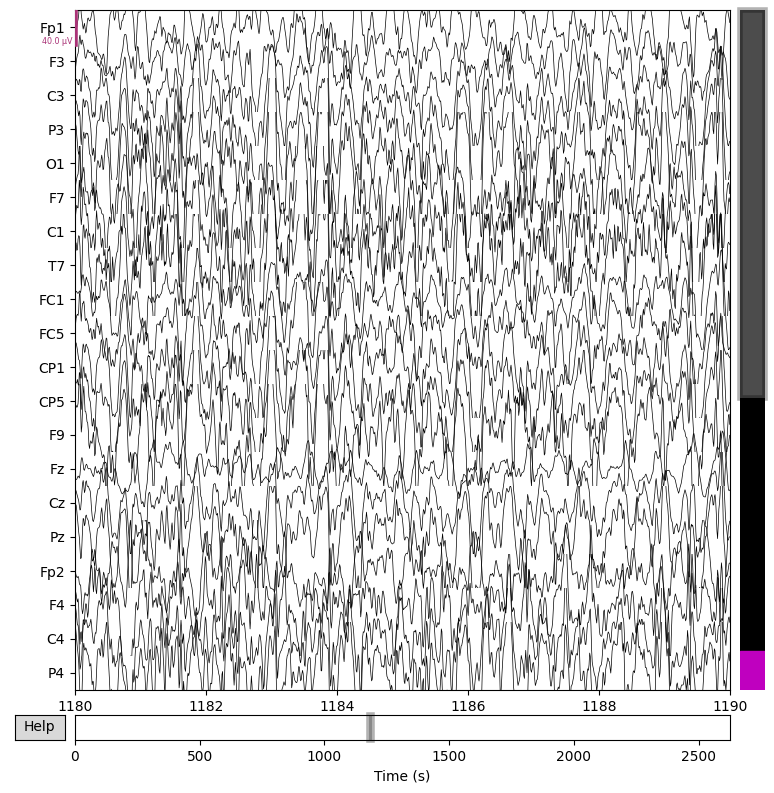

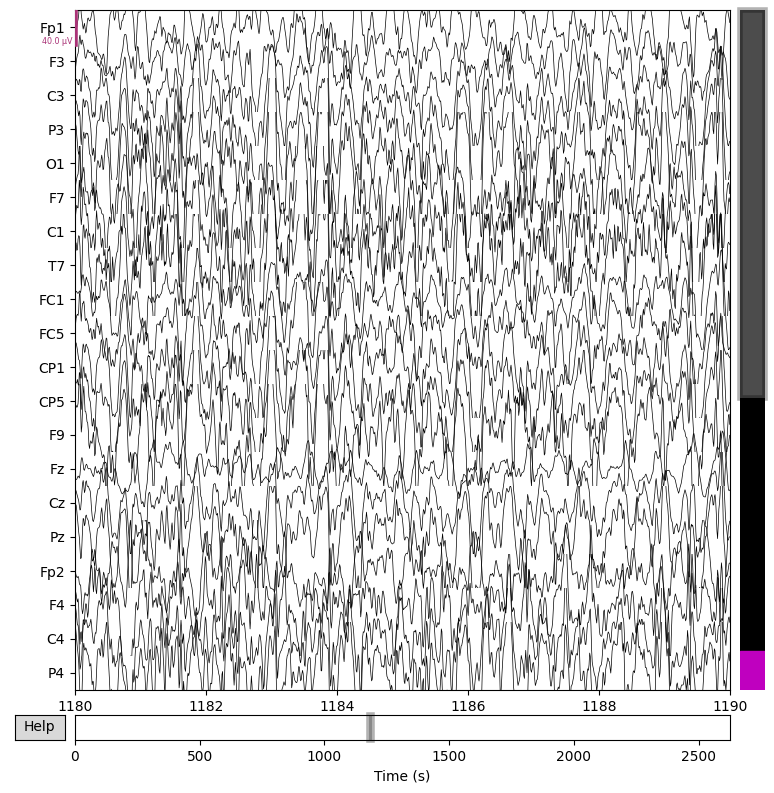

In [61]:
raw.plot(title = "Normal EEG plot", start=1180, duration = 10)

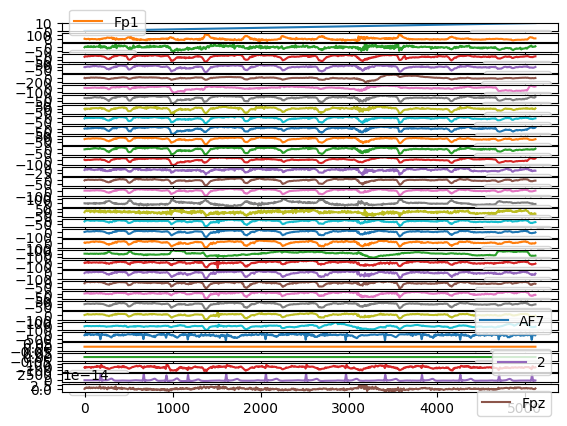

<Figure size 10000x10000 with 0 Axes>

In [62]:
normal_eeg_10s = normal_eeg.loc[0:5120]
normal_eeg_10s.plot.line(subplots=True)
plt.figure(figsize = (100, 100))
plt.show()

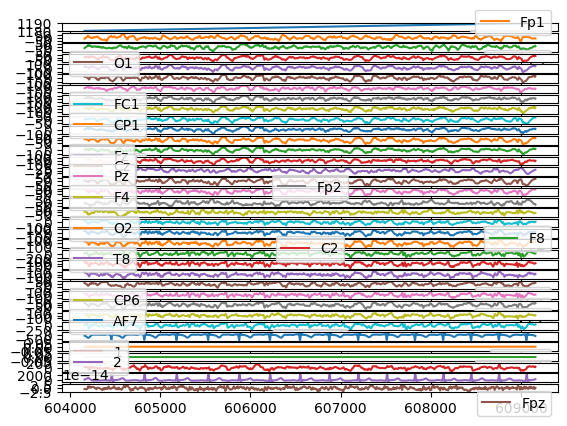

<Figure size 10000x10000 with 0 Axes>

In [63]:
abnormal_eeg_10s = abnormal_eeg.loc[604160:609160]
abnormal_eeg_10s.plot.line(subplots=True)
plt.figure(figsize = (100, 100))
plt.show()

In [64]:
normal_eeg.drop(['Iz', 'AF8','1','2','time'],axis=1)
abnormal_eeg.drop(['Iz', 'AF8','1','2','time'],axis=1)

Fp1         F3         C3         P3         O1         F7  \
604160 -16.634512 -17.093443   7.560459  21.224856  37.190053   7.586916   
604161 -15.951808 -15.924142   8.850139  23.072499  39.432579   7.931841   
604162 -15.182963 -14.557120  10.278303  25.062873  41.571473   8.644140   
604163 -14.337796 -13.046316  11.764927  27.069562  43.464283   9.660443   
604164 -13.426770 -11.452790  13.221104  28.952556  44.970720  10.892293   
...           ...        ...        ...        ...        ...        ...   
625660 -56.760886 -15.252023  12.456758  38.255999  60.349348 -46.164542   
625661 -57.993893 -14.422138  13.844732  38.620414  58.907308 -46.917660   
625662 -59.314621 -13.286835  15.483334  39.207487  57.120487 -47.920595   
625663 -60.622706 -12.057254  17.129401  39.970713  55.223614 -49.040659   
625664 -61.835760 -10.955323  18.552987  40.849079  53.484574 -50.156050   

               C1         T7        FC1       FC5  ...          F8  \
604160  15.484600  13.520885   2.460110  3.035157  ...   20.861144   
604161  15.032930  13.383658   2.960515  3.706365  ...   21.052397   
604162  14.850114  14.017668   3.557575  4.629317  ...   21.216562   
604163  14.999949  15.351854   4.217303  5.772901  ...   21.496636   
604164  15.506097  17.206101   4.899117  7.083365  ...   21.983772   
...           ...        ...        ...       ...  ...         ...   
625660  14.282802  62.706259  17.704232  0.985334  ...  137.454485   
625661  15.077633  62.177727  18.110122  1.718444  ...  136.231719   
625662  17.815473  60.840618  18.725512  3.312930  ...  135.805165   
625663  22.247680  59.144380  19.439176  5.583099  ...  136.274513   
625664  27.874043  57.587672  20.134417  8.242749  ...  137.585201   

                C2         T8        FC2         FC6        CP2        CP6  \
604160   59.170780  90.569166  20.437506   36.563353  41.302779  75.648362   
604161   57.178336  87.151777  19.943042   36.011268  40.919992  73.929343   
604162   55.159702  83.559890  19.377126   35.431114  40.513728  72.028270   
604163   53.294193  80.111262  18.744927   34.932132  40.074365  70.009666   
604164   51.694623  77.057256  18.050419   34.579276  39.581592  67.912100   
...            ...        ...        ...         ...        ...        ...   
625660  108.205799  89.589210  50.242934  106.063147  59.846606  98.316714   
625661  104.472932  90.463362  50.553925  107.900647  60.178510  98.256166   
625662   99.100824  91.024307  51.033829  108.260800  60.539871  98.138865   
625663   92.851870  91.325772  51.670743  107.030706  60.905094  97.923868   
625664   86.586382  91.464567  52.442490  104.304914  61.251974  97.579990   

               F10        AF7           Fpz  
604160   29.605466 -42.530637 -6.185854e-15  
604161   29.052496 -46.360376 -6.528659e-15  
604162   28.729633 -50.236216 -6.746886e-15  
604163   28.797653 -54.235929 -6.836500e-15  
604164   29.336789 -58.433799 -6.813124e-15  
...            ...        ...           ...  
625660  145.686447  22.081148 -9.757602e-15  
625661  143.569330  29.251244 -8.164560e-15  
625662  141.549611  35.509497 -6.635262e-15  
625663  139.908957  40.015112 -5.256813e-15  
625664  138.850705  42.024029 -4.081481e-15  

[21505 rows x 31 columns]

In [65]:
normal_eeg.insert(2,'seizure',0)
abnormal_eeg.insert(2,'seizure',1)

In [66]:
complete_df_with_annotation =  pd.concat([normal_eeg, abnormal_eeg],axis=0)

In [67]:
X = complete_df_with_annotation.drop(['seizure'],axis=1)
Y = complete_df_with_annotation.seizure

In [69]:
print (X.shape[1])
print (Y.shape)

36
(1344002,)


In [70]:
Y.unique()

array([0, 1])

In [71]:

import seaborn as sns

In [72]:
cols = complete_df_with_annotation.columns
tgt = complete_df_with_annotation.seizure
tgt[tgt > 1] = 0
ax = sns.countplot(tgt,label="Count")
non_seizure, seizure = tgt.value_counts()
print('The number of trials for the non-seizure class is:', non_seizure)
print('The number of trials for the seizure class is:', seizure)

The number of trials for the non-seizure class is: 1322497
The number of trials for the seizure class is: 21505


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size=0.5,random_state=42)

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [75]:
print("The shape of the training set is :{}".format(X_train.shape))
print("The shape of the testing set is :{}".format(X_test.shape))
print("The shape of the validation set is :{}".format(X_val.shape))

The shape of the training set is :(1075201, 36)
The shape of the testing set is :(134401, 36)
The shape of the validation set is :(134400, 36)


In [94]:
from sklearn.ensemble import RandomForestClassifier

In [96]:
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier(max_depth=10,random_state=69)
random.fit(X_train,y_train)

#predicting
y_pred = random.predict(X_val) 
#Evaluating the model
precision = metrics.accuracy_score(y_pred,y_val)* 100
#print  the accuracy
print("Accuracy of the model by using the random algorithm : {0:.2f}%".format(precision))

Accuracy of the model by using the random algorithm : 99.60%


In [97]:
# calculate the FPR and TPR for all thresholds of the classification
y_pred = random.predict(X_val)
#y_pred = y_pred[:, 1]
random_fpr, random_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
random_auc = metrics.roc_auc_score(y_val, y_pred)

In [98]:
random_auc

0.8775369003690037

In [99]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= 100)
knn.fit(X_train,y_train)

y_pred = knn.predict(X_val)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_val) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))
print(classification_report(y_val,y_pred))

Accuracy with K-NN: 99.12%
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    132232
           1       0.96      0.47      0.64      2168

    accuracy                           0.99    134400
   macro avg       0.98      0.74      0.82    134400
weighted avg       0.99      0.99      0.99    134400



In [100]:
# calculate the FPR and TPR for all thresholds of the classification
y_pred = knn.predict(X_val)
#y_pred = y_pred[:, 1]
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
knn_auc = metrics.roc_auc_score(y_val, y_pred)

In [101]:
#now checking the accuracy on the decision tree classification
from sklearn import tree
tree_eeg = tree.DecisionTreeClassifier()
tree = tree_eeg.fit(X_train,y_train)
#predicting
y_pred = tree.predict(X_val) 
#Evaluating the model
precision = metrics.accuracy_score(y_pred,y_val)* 100
#print  the accuracy
print("Accuracy of the model by using the decision tree algorithm : {0:.2f}%".format(precision))

Accuracy of the model by using the decision tree algorithm : 100.00%


In [103]:
from xgboost import XGBClassifier
import xgboost as xgb
xgbc = XGBClassifier()

xgbc.fit(X_train,y_train)

print("XGBoost")
#predicting
y_pred = xgbc.predict(X_val) 
#Evaluating the model
precision = metrics.accuracy_score(y_pred,y_val)* 100
#print  the accuracy
print("Accuracy of the model by using the xgbc algorithm : {0:.2f}%".format(precision))

XGBoost
Accuracy of the model by using the xgbc algorithm : 100.00%


In [ ]:
from tensorflow.keras.optimizers import Adam

In [77]:
def create_model(max_length, vocab_size, embedding_dim):
    inputs = tf.keras.Input(shape=(max_length,))
    embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    gru = tf.keras.layers.GRU(256, return_sequences=True)(embedding)
    flatten = tf.keras.layers.Flatten()(gru)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model


In [78]:
max_length = 100 
vocab_size = 5
embedding_dim =100
grumodel = create_model(max_length, vocab_size, embedding_dim)
grumodel.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 100)          500       
                                                                 
 gru_1 (GRU)                 (None, 100, 256)          274944    
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25601     
                                                                 
Total params: 301,045
Trainable params: 301,045
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
grumodel.fit(X, Y, epochs=10, validation_split=0.2)

In [ ]:
y_pred = grumodel.predict(X_val)
pred_labels =np.round(predictions)       
score = accuracy_score(y_val,pred_labels)
conf_mx = confusion_matrix(y_val, pred_labels)